In [108]:
import matplotlib.pyplot as plt
import numpy as np
import itertools



def recall(W, act, max_iter=10000, little_model=False, show_step=False, show_pic=False):
    prev_prev_act = None
    prev_act = act
    for i in range(max_iter):
        # print(i)
        new_act = update_neurons(W, prev_act, little_model=little_model, show_step=show_step, show_pic=show_pic)
        if np.array_equal(new_act, prev_act):
            return [new_act]
        if little_model and np.array_equal(new_act, prev_prev_act):
            return [new_act, prev_act]
        prev_prev_act = prev_act
        prev_act = new_act
    return new_act


def update_neurons(W, act, little_model=True, show_step=False, show_pic=False):
    if little_model:
        return np.sign(np.sum(W*act, axis=1))
    activations = np.copy(act)
    order = np.arange(len(act))
    np.random.shuffle(order)
    for i in order:
        if show_step and i%100 == 0:
            if show_pic:
                print_pic(activations)
            print(energy(W, activations))
        activations[i] = np.sign(np.sum(W[i,:]*activations))
    return activations


def sparse_recall(W, act, theta=1, max_iter=50):
    old = np.copy(act)
    new = sparse_update_neurons(W, old, theta=theta)
    tour = 1
    while not np.array_equal(old, new) or tour >= max_iter:
        new, old = sparse_update_neurons(W, new, theta=theta), new
        tour += 1
    return new


def sparse_update_neurons(W, act, theta=1):
    res = np.copy(act)
    for i in range(len(act)):
        res[i] = 0.5 + 0.5 * np.sign(np.dot(W[i], act) - theta)
    return res


def learn(patterns, W=None, nodiag=True, scale=True):
    P = np.shape(patterns)[0] # Number of patterns
    N = np.shape(patterns)[1] # Number of units
    if W is None:
        W = np.zeros((N, N))
    for u in range(P):
        W += np.outer(patterns[u], patterns[u])
    if nodiag:
        W -= np.diag(np.diag(W)) # Remove self-connections

    if scale:
        return W/N
    else:
        return W


def sparse_learn(patterns, activity):
    P = np.shape(patterns)[0] # Number of patterns
    N = np.shape(patterns)[1] # Number of units
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            for u in range(P):
                W[i][j] += (patterns[u][i]-activity)*(patterns[u][j]-activity)
    W -= np.diag(np.diag(W)) # Remove self-connections
    return W


def attractors(W, pattern_dim):
    res = 0
    attr = []
    for pattern in list(itertools.product([-1, 1], repeat=pattern_dim)):
        if np.array_equal(pattern, update_neurons(W, pattern)):
            attr.append(pattern)
            res += 1
    return res, attr



def random_weights():
    W = np.random.normal(0, 1, size=(8, 8))
    # print(recall(W, [1, 1,  1, -1,  1, -1, 1,  1], little_model=False, show_step=True))
    print(attractors(W, 8))


def import_pict():
    return np.reshape(np.loadtxt('pict.dat', delimiter=','), (11, 1024))


def print_pic(pic):
    # Build image
    img = np.zeros((32, 32, 3))
    for i in range (32):
        for j in range(32):
            img[i][j] = [0, 0, 0] if pic[i*32+j]==-1 else [1, 1, 1]
    plt.imshow(img)
    plt.show()



def random_pics_capacity_stats():
    nb_patterns = np.arange(5, int(0.138*1024)+5, 5)
    repeat = 10
    n = 1024
    noise_amount = int(0.05*n)
    stats = np.zeros((len(nb_patterns), 4))
    for i in range(len(nb_patterns)):
        scores = []
        #stability_scores = []
        for _ in range(repeat):
            patterns = np.sign(np.random.uniform(-1, 1, (nb_patterns[i],n)))
            W = learn(patterns, nodiag=False)
            score = 0
            #stability_score = 0
            for p in range(len(patterns)):
                noisy_p = np.copy(patterns[p])
                indexes = np.random.choice(n, noise_amount, replace=False)
                for j in indexes:
                    noisy_p[j] *= -1
                if (np.array_equal(recall(W, noisy_p, little_model=True)[0], patterns[p])):
                    score += 1
#                 if np.array_equal(update_neurons(W, patterns[p]), patterns[p]):
#                     stability_score += 1
            scores.append(score/nb_patterns[i])
#             stability_scores.append(stability_score/nb_patterns[i])
        stats[i][0] = np.average(scores)
        print(nb_patterns[i], ":", stats[i][0])
        stats[i][1] = np.std(scores)
#         stats[i][2] = np.average(stability_scores)
#         stats[i][3] = np.std(stability_scores)
    plt.errorbar(nb_patterns, stats[:, 0], yerr=stats[:, 1], label="Score (5% noise)")
    #plt.errorbar(nb_patterns, stats[:, 2], yerr=stats[:, 3], label="Stability score")
    plt.ylim(0, 1)
    plt.xlabel("Number of learned patterns")
    plt.ylabel("Score for recontructing noisy patterns")
    plt.title("Capacity of network")
    plt.legend(loc="lower left")
    plt.show()


def add_noise(noise_prop, pattern):
    n = len(pattern)
    noisy_p = np.copy(pattern)
    indexes = np.random.choice(n, int(noise_prop * n), replace=False)
    for j in indexes:
        noisy_p[j] *= -1
    return noisy_p



def capacity():
    """
    manually search for how many patterns can be stored
    :return:
    """
    storage = 4
    noise_rate = 0
    pictures = import_pict()
    patterns, distorted_patterns = np.split(pictures, [9])
    #p = np.array([patterns[1], patterns[2], patterns[3], patterns[4]])
    p = np.array([patterns[1], patterns[4], patterns[7], patterns[8]])
    W = learn(p)

    for i in range(storage):
        noisy_pattern = add_noise(noise_rate, p[i])
        pic = recall(W, noisy_pattern)[0]
        if np.array_equal(pic, p[i]) is False:
            print("pic", i, "not correctly recalled")
        else:
            print("pic", i, "correctly recalled")
        print_pic(pic)


def hundred_unit():
    """
    trains 300 patterns on a 100 unit network
    :return:
    """
    #patterns = np.random.choice([-1, 1], (300, 10), replace=True)
    W = np.zeros((10, 10))
    stable = np.zeros(300)
    f1_stable = np.zeros(300)
    patterns = np.sign(0.5 + np.random.normal(0, 1, size=(300, 10)))

    for i in range(300):
        W = learn(patterns[:i+1], nodiag=False, scale=True)
        for j in range(i+1):
            p = patterns[j]
            out = recall(W, p, max_iter=1)[0]

            # distortion
            flip1 = add_noise(0.1, patterns[j])
            flip1 = recall(W, flip1, max_iter=50)[0]

            if np.array_equal(patterns[j], flip1):
                f1_stable[i] += 1
                # print("pattern", j, "recalled for", i, "stored images")

            if np.array_equal(patterns[j], out):
                stable[i] += 1
                #print(patterns[j])

    x = np.arange(1, 301, 1)
    plt.plot(x, stable, x, f1_stable )
    plt.xlabel("Number of patterns added")
    plt.ylabel("Number of stable patterns")
    plt.title("100-unit network")
    plt.legend(["No distortion", "1 flipped unit"])
    plt.show()


def sparse_patterns():
    activity = 0.01
    n = 100
    thetas = np.arange(0, 2, 0.2)
    #thetas = [1.2]
    noise_qty = int(0.05*n)
    repeat = 5
    stats = np.zeros((len(thetas),))
    #for i in range(len(thetas)):
    for i in range(len(thetas)):
        #print("theta", thetas[i])
        for nb_patterns in range(2, 14, 2):
            for _ in range(5):
                patterns = np.zeros((nb_patterns, n))
                indexes = np.random.choice(n*nb_patterns, int(activity*n*nb_patterns), replace=False)
                print('nb_patterns  : '+str(nb_patterns))
                print('indexes')
                print(indexes)
                
                for index in indexes:
                    n_pattern = index // n
                    n_unit = index % n
                    patterns[n_pattern][n_unit] = 1
                W = sparse_learn(patterns, activity)
                score = 0
                print('nb_patterns : '+str(nb_patterns))
                print('-----------')
                for j in range(nb_patterns):
                    act = sparse_update_neurons(W, patterns[j], theta=thetas[i])
                    if np.array_equal(patterns[j], act):
                        score += 1
#                 score = score/nb_patterns
#             stats[i] = np.average(scores)
                if score == nb_patterns:
                    stats[i] = nb_patterns

    #plt.plot(thetas, stats, label="Number of patterns")
    plt.plot(thetas, stats)
    plt.xlabel("Theta")
    plt.ylabel("Number of patterns")
    plt.title("Number of retrievable patterns (p="+str(activity)+")")
    plt.legend(loc="lower left")
    plt.show()


In [110]:
thetas = np.arange(0, 2, 0.2)
print(thetas)

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


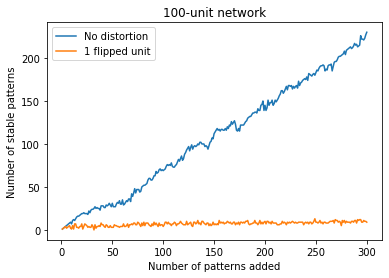

In [96]:
hundred_unit()

In [21]:
from random import randrange
def real_random_update_til_converge(pattern, W, 
                        return_iterations=True,max_iter=10000):
    prev_act = pattern
    new_act = np.zeros(pattern.shape)
    iterations = 0
    while not (prev_act == new_act).all():
        prev_act = new_act        
        #random_i = randrange(weights.shape[0])
        new_act = update_neurons(W, prev_act)
        iterations += 1
        if iterations>max_iter:
            print('could not restore')
            break
    print(iterations)    
    if return_iterations:
        return new_act, iterations
    
    return new_act

In [25]:
pictures = import_pict()
patterns, distorted_patterns = np.split(pictures, [9])
p = np.array([patterns[0], patterns[1], patterns[2], patterns[3]])
# weights = learn(p)
# updated = real_random_update_til_converge(p[1], weights, return_iterations=True)

In [127]:
def add_noise(pattern, ratio):
    new_pattern = np.array(pattern)
    indices = np.random.choice(np.arange(len(pattern)), 
                               size=int(ratio*len(pattern)),
                               replace=False)
    new_pattern[indices] = np.where(pattern[indices] == 1, -1, 1)
    return new_pattern

In [42]:
def real_random_update_til_converge(pattern, weights, 
                        return_iterations=True):
    updated = pattern
    prev = np.zeros(pattern.shape)
    iterations = 0
    while not (updated == prev).all():
        prev = updated        
        random_i = randrange(weights.shape[0])
        updated[random_i] = update_rule(prev, weights[random_i,:])
        
        iterations += 1
        
    if return_iterations:
        return updated, iterations
    
    return updated

In [29]:
def update_rule(pattern, weights):
    return sign(np.dot(pattern, weights))

In [129]:
def recall(W, act, max_iter=10000, little_model=False, show_step=False, show_pic=False):

    prev_prev_act = None
    prev_act = act
    for i in range(max_iter):
        # print(i)
        new_act = update_neurons(W, prev_act, little_model=little_model, show_step=show_step, show_pic=show_pic)
        if (new_act == prev_act).all():
            return True,i
#         if np.array_equal(new_act, prev_act):
#             return True,i
        prev_act = new_act
    return False,i

In [136]:
pictures = import_pict()
patterns, distorted_patterns = np.split(pictures, [9])
p = np.array([patterns[4], patterns[1], patterns[2], patterns[4]])
PATTERNS = {"p1": p[0], "p2": p[1], "p3":p[2], "p7":p[3]}
MAX_RATIO = 0.1
weights = learn(p)

def convergence_of_noisy_patterns(patterns_dict, weights, max_ratio, iterations=10):
    converges = {}
    #terations_count = {}
    ratios = np.arange(0, max_ratio, 0.01)

    for pattern in patterns_dict:
        print(pattern)
        print(len(patterns_dict[pattern]))
        converges[pattern] = []
        #terations_count[pattern] = []
        
        for ratio in ratios:
            score_sum = 0.0
            iterations_sum = 0.0
           
            #or iteration in range(iterations):
            noise_pattern = add_noise(patterns_dict[pattern], ratio)
            #pdated, update_iters = real_random_update_til_converge(noise_pattern, weights, True)
            check, update_iters =recall(weights,noise_pattern)
            if check:
                print('pattern : '+str(pattern))
                print('success')
                print(update_iters)
            else:
                print('pattern : '+str(pattern))
                print('fail')  
            #terations_sum += update_iters

            converges[pattern].append(score_sum/iterations)
            #terations_count[pattern].append(iterations_sum/iterations)
        
#     fig = plt.figure()
#     for val in patterns_dict.keys():
#         plt.plot(ratios, converges[val], label=val)
#     plt.legend()
#     plt.xlabel("Ratio")
#     plt.ylabel("Avg Score")
#     plt.title("Classification of noisy training patterns")
    
#     return fig

In [137]:
def sign(x):
    return np.where(x < 0, -1, 1)

In [138]:
convergence_of_noisy_patterns(PATTERNS, weights, MAX_RATIO, iterations=1000)

p1
1024
pattern : p1
success
0
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
pattern : p1
success
1
p2
1024
pattern : p2
success
2
pattern : p2
success
2
pattern : p2
success
2
pattern : p2
success
2
pattern : p2
success
2
pattern : p2
success
3
pattern : p2
success
2
pattern : p2
success
2
pattern : p2
success
3
pattern : p2
success
3
p3
1024
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
3
pattern : p3
success
2
pattern : p3
success
2
pattern : p3
success
3
p7
1024
pattern : p7
success
0
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1
pattern : p7
success
1


pic 0 correctly recalled


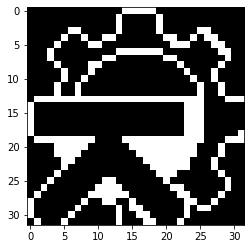

pic 1 correctly recalled


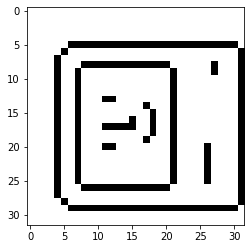

pic 2 correctly recalled


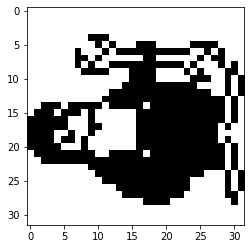

pic 3 correctly recalled


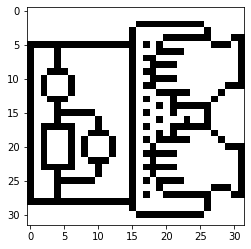

In [70]:
##3.5.1
capacity()

### random patterns have better performance than pictures

5 : 1.0
10 : 1.0
15 : 1.0
20 : 1.0
25 : 1.0
30 : 1.0
35 : 1.0
40 : 1.0
45 : 1.0
50 : 0.998
55 : 0.9927272727272728
60 : 0.9833333333333332
65 : 0.9676923076923079
70 : 0.9414285714285715
75 : 0.9093333333333333
80 : 0.8712500000000001
85 : 0.8070588235294117
90 : 0.7288888888888889
95 : 0.6610526315789473
100 : 0.5780000000000001
105 : 0.47714285714285715
110 : 0.4354545454545454
115 : 0.3173913043478261
120 : 0.29666666666666663
125 : 0.22160000000000002
130 : 0.17384615384615387
135 : 0.12592592592592594
140 : 0.08785714285714284
145 : 0.059310344827586216


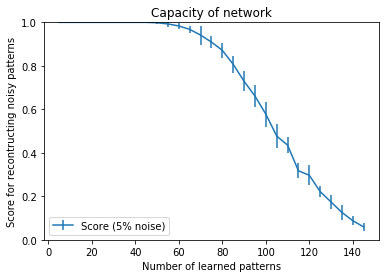

In [5]:
##3.5.2&3.5.3
random_pics_capacity_stats()

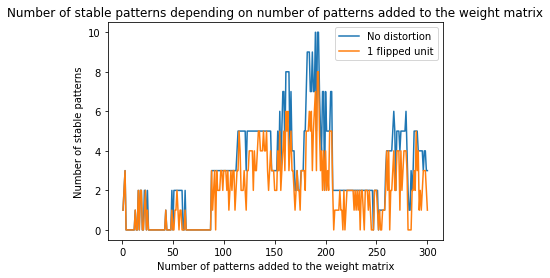

In [81]:
##3.5.4&3.5.5
hundred_unit()